In [ ]:
!pip install ultralytics tensorflow torch onnx onnxsim onnx2tf
!pip install roboflow

In [ ]:
%ls /content/drive/MyDrive/Colab\ Notebooks/ScanLib/modèle


best-v1.onnx  best-v1.pt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Nous allons, dans cette partie, convertir le modèle en tensorflow lite**

# **Chargement du modèle:**

In [ ]:
from ultralytics import YOLO

model = YOLO("/content/drive/MyDrive/Colab Notebooks/ScanLib/modèle/best-v1.pt")
# Affiche le résumé du modèle
model.info()

Model summary: 129 layers, 3,011,043 parameters, 0 gradients, 8.2 GFLOPs


(129, 3011043, 0, 8.1941504)

# **Exporter en TensorFlow SavedModel**

### **Export vers un format onnx dans un premier temps**

In [ ]:
model.export(format="onnx")


Ultralytics 8.3.133 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/content/drive/MyDrive/Colab Notebooks/ScanLib/modèle/best-v1.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)

ONNX: starting export with onnx 1.18.0 opset 19...
ONNX: slimming with onnxslim 0.1.52...
ONNX: export success ✅ 1.5s, saved as '/content/drive/MyDrive/Colab Notebooks/ScanLib/modèle/best-v1.onnx' (11.7 MB)

Export complete (2.2s)
Results saved to /content/drive/MyDrive/Colab Notebooks/ScanLib/modèle
Predict:         yolo predict task=detect model=/content/drive/MyDrive/Colab Notebooks/ScanLib/modèle/best-v1.onnx imgsz=640  
Validate:        yolo val task=detect model=/content/drive/MyDrive/Colab Notebooks/ScanLib/modèle/best-v1.onnx imgsz=640 data=/content/book-spine-detection-1/data.yaml  
Visualize:       https://netron.app


'/content/drive/MyDrive/Colab Notebooks/ScanLib/modèle/best-v1.onnx'

### **conversion manuelle du .onnx en .tf**

In [ ]:
!onnx2tf --input_onnx_file_path=/content/drive/MyDrive/Colab\ Notebooks/ScanLib/modèle/best-v1.onnx --output_folder_path=/content/drive/MyDrive/Colab\ Notebooks/ScanLib/modèle/best_tf


E0000 00:00:1747225272.282751   62001 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747225272.296425   62001 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered

Model optimizing started ============================================================
Simplifying...
Finish! Here is the difference:
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃            ┃ Original Model ┃ Simplified Model ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Add        │ 9              │ 8                │
│ Concat     │ 19             │ 19               │
│ Constant   │ 144            │ 143              │
│ Conv       │ 64             │ 64               │
│ Div        │ 2              │ 1                │
│ MaxPool    │ 3              │ 3                │
│ Mul        │ 59             │ 58               │
│ R

### **Conversion du format tf en tflite**

In [ ]:
import tensorflow as tf

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("/content/drive/MyDrive/Colab Notebooks/ScanLib/modèle/best_tf")
tflite_model = converter.convert()

with open("/content/drive/MyDrive/Colab Notebooks/ScanLib/modèle/best-v1.tflite", "wb") as f:
    f.write(tflite_model)

In [ ]:
%ls /content/drive/MyDrive/Colab\ Notebooks/ScanLib/modèle

best_tf/  best-v1.onnx  best-v1.pt  best-v1.tflite


# **Comparer yolov8n.pt et yolov8n.tflite**

### Code pour voir le résultat de du version .pt

In [ ]:
from ultralytics import YOLO

model = YOLO("/content/drive/MyDrive/Colab Notebooks/ScanLib/modèle/best-v1.pt")

### Affichage résulat .pt


0: 640x512 19 0s, 181.8ms
Speed: 6.3ms preprocess, 181.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)
Results saved to runs/detect/predict3


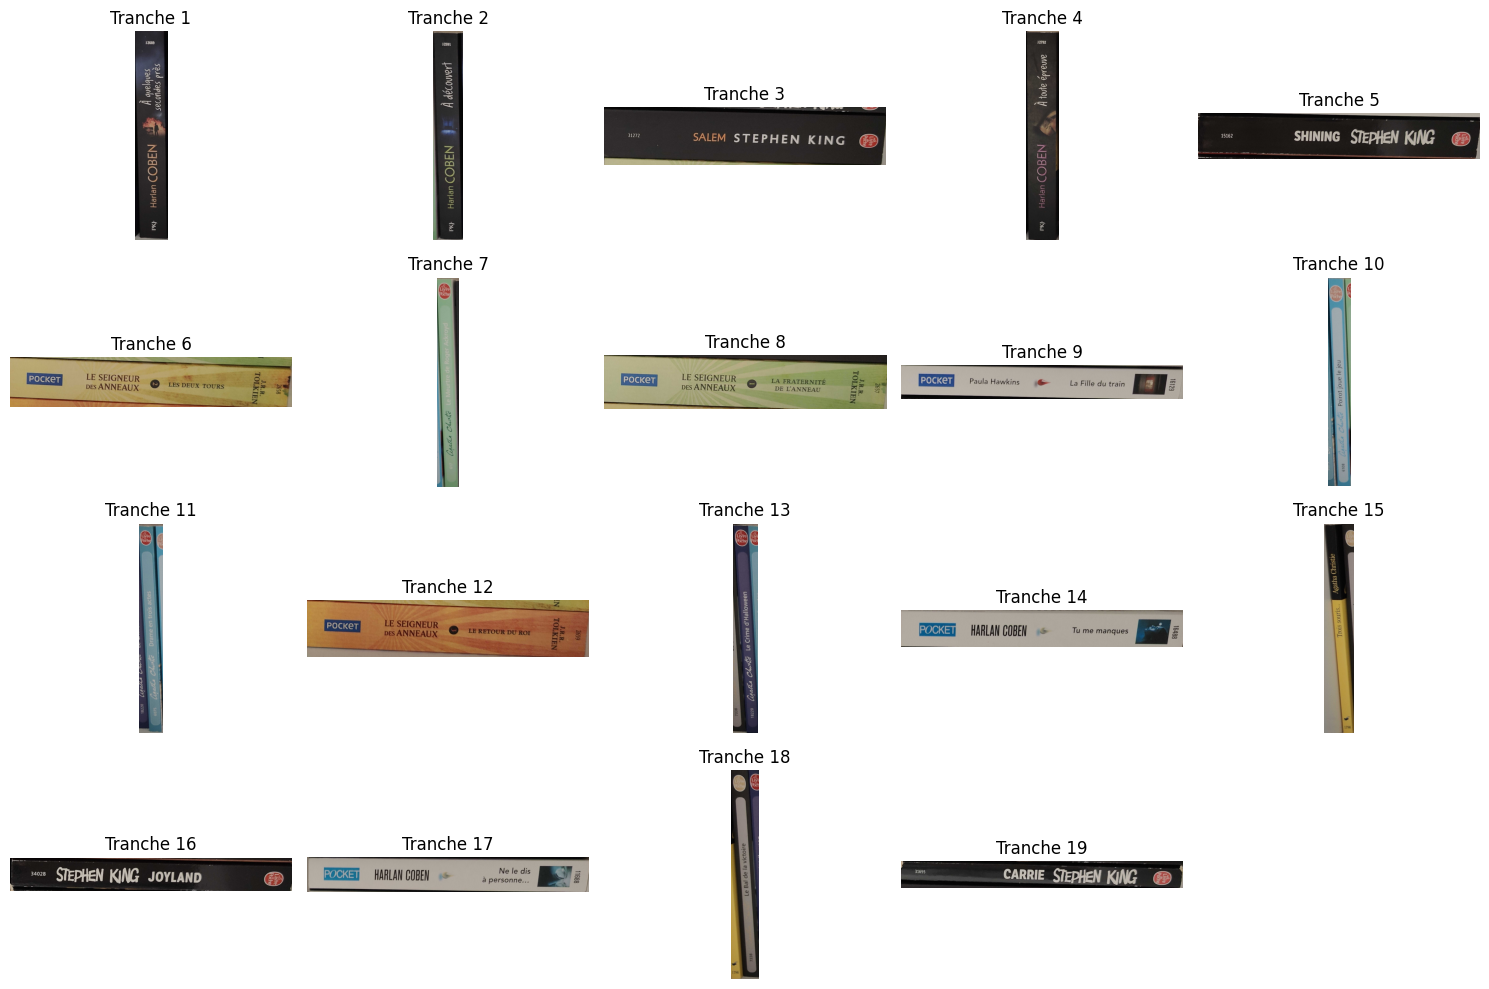

In [ ]:
import cv2
import matplotlib.pyplot as plt
# Recharger l'image originale
image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/ScanLib/biblio1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width, _ = image.shape
results = model.predict(image, save=True, conf=0.25)

# Extraire les boîtes depuis results
boxes = results[0].boxes

# Afficher les tranches détectées
plt.figure(figsize=(15, 10))

for i, box in enumerate(boxes):
    xyxy = box.xyxy[0].cpu().numpy().astype(int)  # x1, y1, x2, y2
    x1, y1, x2, y2 = xyxy
    crop = image[y1:y2, x1:x2]

    # Afficher la tranche
    plt.subplot(4, 5, i + 1)  # Ajuste en fonction du nombre total
    plt.imshow(crop)
    plt.axis("off")
    plt.title(f"Tranche {i+1}")

plt.tight_layout()
plt.show()

### **MODÈLE AU FORMAT TENSORFLOW LITE**

### ETAPE 1 : Chargement et préparation de l'image

Image prête : (1, 640, 640, 3)


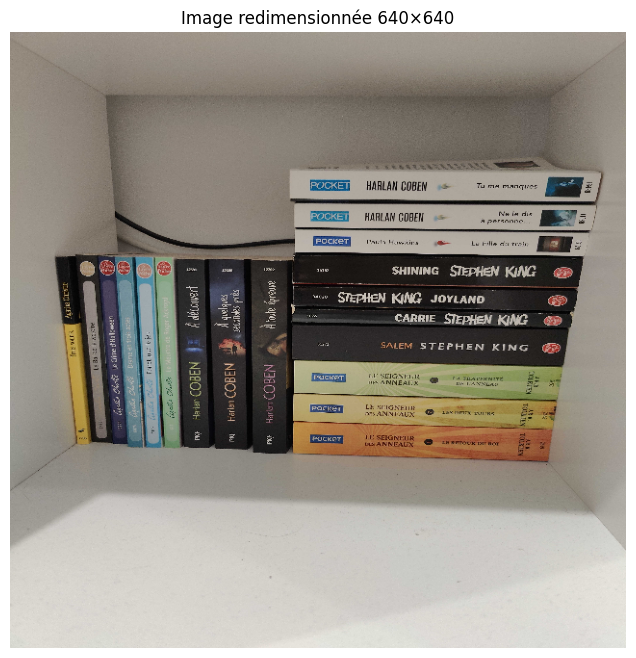

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Chemin vers l'image test
image_path = "/content/drive/MyDrive/Colab Notebooks/ScanLib/biblio1.jpg"

# Lire l’image
image = cv2.imread(image_path)
assert image is not None, "Image introuvable"

# Convertir BGR → RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Redimensionner à 640×640 (taille d’entrée de YOLOv8)
resized = cv2.resize(image_rgb, (640, 640))

# Normaliser (0-1) et convertir en float32
input_data = resized / 255.0
input_data = input_data.astype(np.float32)

# Ajouter la dimension batch (1, 640, 640, 3)
input_data = np.expand_dims(input_data, axis=0)
print("Image prête :", input_data.shape)

#affichage de l'image risized à 640x640
plt.figure(figsize=(8, 8))
plt.imshow(resized)
plt.axis("off")
plt.title("Image redimensionnée 640×640")
plt.show()



### ETAPE 2 : Chargement du modèle Tflite

In [ ]:
import tensorflow as tf

# Chemin du modèle .tflite
model_path = "/content/drive/MyDrive/Colab Notebooks/ScanLib/modèle/best-v1.tflite"

# Charger le modèle TFLite
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Détails des entrées/sorties
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Modèle TFLite chargé")
print("Entrée attendue :", input_details[0]['shape'], input_details[0]['dtype'])
print("Sortie prévue :", output_details[0]['shape'])


Modèle TFLite chargé
Entrée attendue : [  1 640 640   3] <class 'numpy.float32'>
Sortie prévue : [   1    5 8400]


### ETAPE 3 : Lancement de la prédiction

In [ ]:
# Injecter l’image dans le modèle
interpreter.set_tensor(input_details[0]['index'], input_data)

# Exécuter l'inférence
interpreter.invoke()

# Récupérer la sortie
output_data = interpreter.get_tensor(output_details[0]['index'])

print("Inférence terminée")
print("Forme de sortie :", output_data.shape)
print("Exemple de 5 premières sorties :", output_data[0][:5])


Inférence terminée
Forme de sortie : (1, 5, 8400)
Exemple de 5 premières sorties : [[     22.335       29.39      37.956 ...      458.42      519.96      583.58]
 [     8.0476      7.7329      6.0618 ...      606.15       601.7      607.84]
 [     44.631      57.167      75.365 ...      361.86      260.74      217.56]
 [     15.687      14.459      11.387 ...      70.191       91.25      157.16]
 [  1.628e-05  1.7024e-05  1.1675e-05 ...  0.00023584  5.5235e-05  3.9875e-05]]


In [ ]:
scores = output_data[0][4]  # shape (8400)
print(output_data.shape)
print(scores)
print(np.max(scores))
print(np.argmax(scores))

(1, 5, 8400)
[  1.628e-05  1.7024e-05  1.1675e-05 ...  0.00023584  5.5235e-05  3.9875e-05]
0.9168331
7176


# ETAPE : Post-traitement et affichage:  

Post-traiement sans NMS

Shape: (8400, 5)
Nombre de boîtes détectées : 179
Score max : 0.9168331
179 boîtes valides conservées


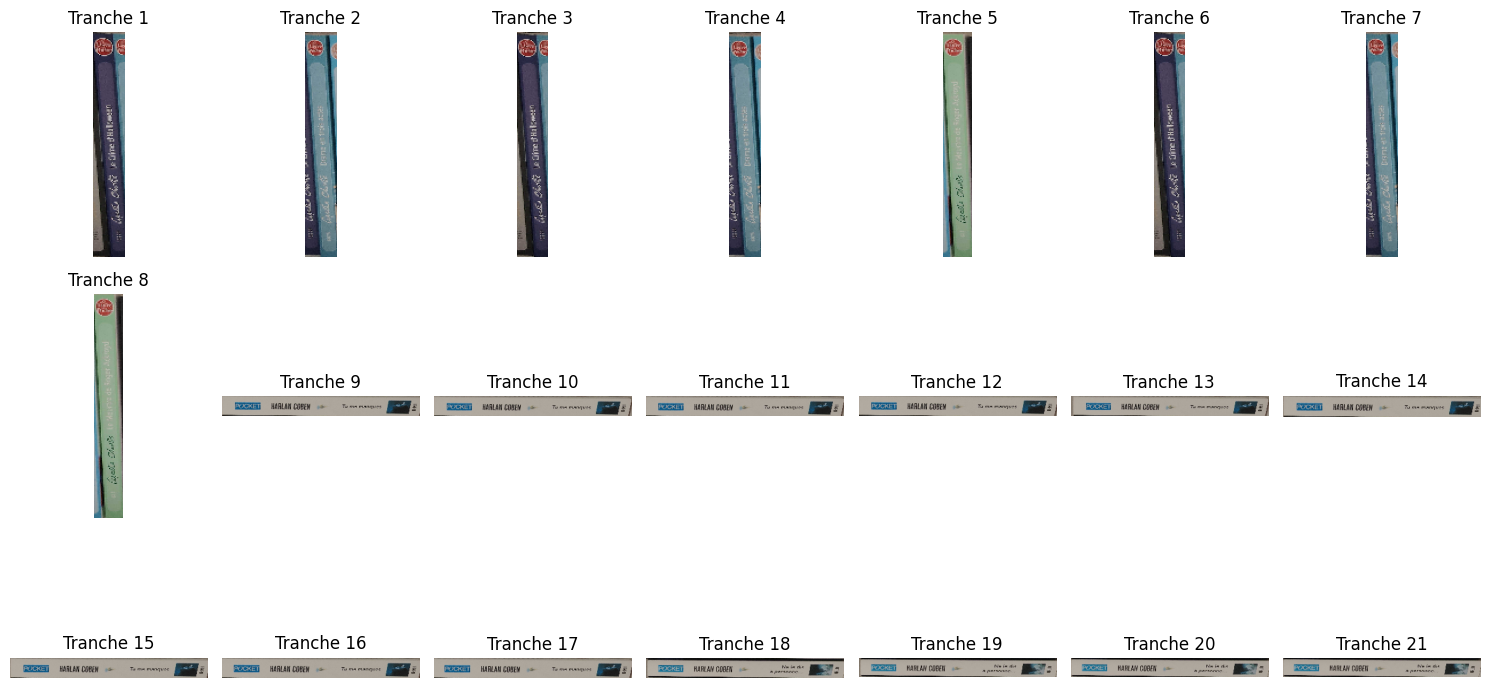

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Étape 1 : Transposer la sortie TFLite
output = output_data[0].T  # shape = (8400, 5)
print("Shape:", output.shape)

# Étape 2 : Extraire [cx, cy, w, h] + scores
boxes_xywh = output[:, :4]
scores = output[:, 4]

# Étape 3 : Filtrer avec seuil
threshold = 0.25
mask = scores > threshold
boxes_xywh = boxes_xywh[mask]
scores = scores[mask]
print("Nombre de boîtes détectées :", len(boxes_xywh))
print("Score max :", np.max(scores))

# Étape 4 : Convertir xywh → xyxy
boxes_xyxy = np.zeros_like(boxes_xywh)
boxes_xyxy[:, 0] = boxes_xywh[:, 0] - boxes_xywh[:, 2] / 2  # x1
boxes_xyxy[:, 1] = boxes_xywh[:, 1] - boxes_xywh[:, 3] / 2  # y1
boxes_xyxy[:, 2] = boxes_xywh[:, 0] + boxes_xywh[:, 2] / 2  # x2
boxes_xyxy[:, 3] = boxes_xywh[:, 1] + boxes_xywh[:, 3] / 2  # y2

# Étape 5 : Convertir en int
boxes = boxes_xyxy.astype(int)

# Étape 6 : Filtrer les boîtes valides dans l'image
h, w, _ = resized.shape
valid_boxes = []
for b in boxes:
    x1, y1, x2, y2 = b
    if x2 > x1 and y2 > y1 and 0 <= x1 < w and 0 <= y1 < h and x2 <= w and y2 <= h:
        valid_boxes.append(b)
valid_boxes = np.array(valid_boxes)
print(f"{len(valid_boxes)} boîtes valides conservées")

# Étape 7 : Affichage des tranches
fig = plt.figure(figsize=(15, 8))
for i, (x1, y1, x2, y2) in enumerate(valid_boxes[:21]):
    crop = resized[y1:y2, x1:x2]
    plt.subplot(3, 7, i+1)
    plt.imshow(crop)
    plt.title(f"Tranche {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


Post-traitement avec NMS

Shape: (8400, 5)
Score max : 0.9168331
Nombre de boîtes détectées : 19
19 boîtes valides conservées après NMS


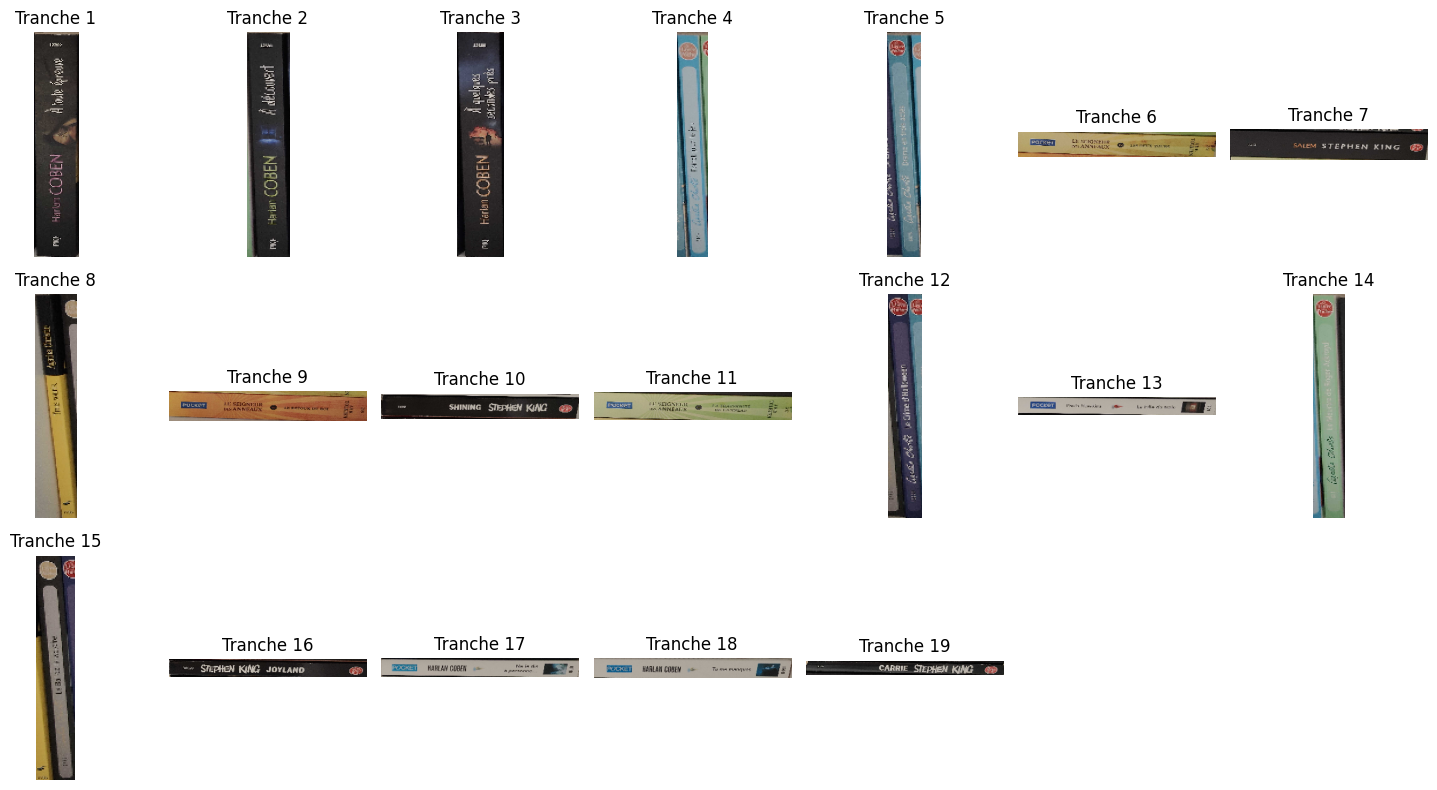

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Étape 1 : Transposer la sortie TFLite
output = output_data[0].T  # shape = (8400, 5)
print("Shape:", output.shape)

# Étape 2 : Extraire [cx, cy, w, h] + scores
boxes_xywh = output[:, :4]
scores = output[:, 4]

# Étape 3 : Filtrer avec seuil
threshold = 0.25
mask = scores > threshold
boxes_xywh = boxes_xywh[mask]
scores = scores[mask]
print("Score max :", np.max(scores))

# Étape 4 : Convertir xywh → xyxy (en float32 pour NMS)
boxes_xyxy = np.zeros_like(boxes_xywh)
boxes_xyxy[:, 0] = boxes_xywh[:, 0] - boxes_xywh[:, 2] / 2  # x1
boxes_xyxy[:, 1] = boxes_xywh[:, 1] - boxes_xywh[:, 3] / 2  # y1
boxes_xyxy[:, 2] = boxes_xywh[:, 0] + boxes_xywh[:, 2] / 2  # x2
boxes_xyxy[:, 3] = boxes_xywh[:, 1] + boxes_xywh[:, 3] / 2  # y2

# Étape 5 : Appliquer Non-Max Suppression (NMS)
boxes_tf = tf.constant(boxes_xyxy, dtype=tf.float32)
scores_tf = tf.constant(scores, dtype=tf.float32)

selected_indices = tf.image.non_max_suppression(
    boxes=boxes_tf,
    scores=scores_tf,
    max_output_size=50,
    iou_threshold=0.5,
    score_threshold=threshold
)

boxes_nms = tf.gather(boxes_tf, selected_indices).numpy().astype(int)
print("Nombre de boîtes détectées :", len(boxes_nms))
# Étape 6 : Filtrer les boîtes valides dans l'image
h, w, _ = resized.shape
valid_boxes = []
for b in boxes_nms:
    x1, y1, x2, y2 = b
    if x2 > x1 and y2 > y1 and 0 <= x1 < w and 0 <= y1 < h and x2 <= w and y2 <= h:
        valid_boxes.append(b)
valid_boxes = np.array(valid_boxes)
print(f"{len(valid_boxes)} boîtes valides conservées après NMS")

# Étape 7 : Affichage des tranches
fig = plt.figure(figsize=(15, 8))
for i, (x1, y1, x2, y2) in enumerate(valid_boxes[:21]):
    crop = resized[y1:y2, x1:x2]
    plt.subplot(3, 7, i+1)
    plt.imshow(crop)
    plt.title(f"Tranche {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()
